# Dataset to YOLO

Esta notebook buscará de pasar el dataset generado con ground of truth de sagemaker a un formato que pueda consumir un modelo de Ultralitics. 

In [19]:
import boto3
import os
from tqdm.auto import tqdm

import time
import json
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# getting results from aws ground of truth

bucket = 'video-tracking-pallets'
obj_key = 'BEMA.mp4/'
local_dir = '/root/video_processing/Pallets/Data/BEMA'

In [16]:
# Create the local directory if it doesn't exist
if not os.path.exists(local_dir):
    os.makedirs(local_dir )

In [18]:
# Download the object
s3 = boto3.client('s3')
# list all objects inside dir
folder_path= ''
objects = s3.list_objects(Bucket=bucket, Prefix=folder_path)
#print(objects)
for obj in objects.get('Contents', []):
    #print(obj)
    files = obj['Key']
    files_processed = obj['Key'].split('/')
    directory = files_processed[0]
    file = files_processed[-1]
    s3.download_file(bucket, files, local_dir + '/' + file)
    print('.', end='', flush=True)
    time.sleep(1)

...................................................................................................................................

In [19]:
# create dataset directory
destination_dir = '/root/video_processing/Pallets/Data/dataset'
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
# create image directory
img_dir = '/root/video_processing/Pallets/Data/dataset/images'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
# create label directory
label_dir = '/root/video_processing/Pallets/Data/dataset/labels'
if not os.path.exists(label_dir):
    os.makedirs(label_dir)

In [20]:
#save images in a folder 
files_array = os.listdir(local_dir)
for i in tqdm(range(len(files_array))):
    if files_array[i].endswith('.jpeg'):
        os.rename(local_dir + "/" + files_array[i], img_dir+ "/" + files_array[i])

  0%|          | 0/130 [00:00<?, ?it/s]

In [21]:
# extract labels for each image
annotations = local_dir + '/'+ 'SeqLabel.json'
with open(annotations, 'r') as f:
    read_labels = json.load(f)

In [22]:
print(read_labels['detection-annotations'][0])

{'annotations': [{'height': 932, 'width': 490, 'top': 88, 'left': 835, 'class-id': '0', 'label-category-attributes': {}}], 'frame-no': '0', 'frame': 'frame_0000.jpeg', 'frame-attributes': {}}


In [23]:
# iterate for each frame
num_frames_annotated = len(read_labels['detection-annotations'])
for i in range(num_frames_annotated):
    # iterate for each bbox found
    num_bbox_found = len(read_labels['detection-annotations'][i]['annotations'])
    for j in range(num_bbox_found):
        # extract class-id
        class_id = read_labels['detection-annotations'][i]['annotations'][j]['class-id']
        # extract frame name
        frame_name = read_labels['detection-annotations'][i]['frame']
        # extract bounding box coordinates
        height_bbox = read_labels['detection-annotations'][i]['annotations'][j]['height']
        width_bbox = read_labels['detection-annotations'][i]['annotations'][j]['width']
        top_bbox = read_labels['detection-annotations'][i]['annotations'][j]['top']
        left_bbox = read_labels['detection-annotations'][i]['annotations'][j]['left']
        # find image dimention
        img = cv.imread(img_dir+ '/' + frame_name)
        height_img = img.shape[0]
        width_img = img.shape[1]
        # normalize coordinates as YOLO
        center_x = (left_bbox + width_bbox / 2) / width_img
        center_y = (top_bbox + height_bbox / 2) / height_img
        width = width_bbox / width_img
        height = height_bbox / height_img
        # write in txt and save in label dir
        frame_name_txt = frame_name.replace('.jpeg', '.txt')
        info_extracted = [class_id, center_x, center_y, width, height]
        with open(label_dir + '/' + frame_name_txt, 'a') as file_txt:
            file_txt.write(str(class_id) + ' ' + str(center_x) + ' ' + str(center_y) 
                           + ' ' + str(width) + ' ' + str(height) + '\n')

In [24]:
# create directories for dataset in train, test, valid
train_dir = '/root/video_processing/Pallets/Data/dataset/train'
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
test_dir = '/root/video_processing/Pallets/Data/dataset/test'
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
valid_dir = '/root/video_processing/Pallets/Data/dataset/valid'
if not os.path.exists(valid_dir):
    os.makedirs(valid_dir)

# create sub-directories for dataset in train, test, valid
sub_dir = ['/root/video_processing/Pallets/Data/dataset/train/images',
           '/root/video_processing/Pallets/Data/dataset/train/labels',
           '/root/video_processing/Pallets/Data/dataset/test/images',
           '/root/video_processing/Pallets/Data/dataset/test/labels',
           '/root/video_processing/Pallets/Data/dataset/valid/images',
           '/root/video_processing/Pallets/Data/dataset/valid/labels']

for sub in sub_dir:
    if not os.path.exists(sub):
        os.makedirs(sub)

In [25]:
train_rate = 0.7
test_rate = 0.1
valid_rate = 0.2

# number of images
num_imgs = len(os.listdir(img_dir))
# number of observations for sets
train_size = int(num_imgs * train_rate)
print("train images: {}".format(train_size))
test_size = num_imgs - int(num_imgs - test_rate * num_imgs)
print("test images: {}".format(test_size))
valid_size = num_imgs - int(num_imgs - valid_rate * num_imgs)
print("valid images: {}".format(valid_size))
# making array of indexes
np.random.seed(0)
permute_idx = np.random.permutation(num_imgs)

#get train data using slicing
train_idx_obs = permute_idx[0:train_size]
print(f"trianing idx {train_idx_obs}")
#get validation data using slicing
valid_idx_obs = permute_idx[train_size:int(num_imgs - test_rate * num_imgs)]
print(f"validation idx {valid_idx_obs}")
#get test data
test_idx_obs = permute_idx[int(num_imgs - test_rate * num_imgs):num_imgs]
print(f"test rows{test_idx_obs}")

train images: 41
test images: 6
valid images: 12
trianing idx [26 35 43 28 11  2 34 46 40 22  4 10 30 41 33 42 48  7 14 32 49 29 37 56
 18 55 27 15  5 31 16 50 20 51  8 13 25 17 58 57 52]
validation idx [38  1 12 45 24  6 23 36 21 19  9 39]
test rows[54  3  0 53 47 44]


In [26]:
# Get image array
imgs = os.listdir(img_dir)
# path for images to train
img_train_dir = '/root/video_processing/Pallets/Data/dataset/train/images'
# move images for training to folder
for idx in train_idx_obs:
    os.rename(img_dir + "/" + imgs[idx], img_train_dir+ "/" + imgs[idx])

# path for images to test
img_test_dir = '/root/video_processing/Pallets/Data/dataset/test/images'
# move images for testing to folder
for idx in test_idx_obs:
    os.rename(img_dir + "/" + imgs[idx], img_test_dir+ "/" + imgs[idx])

# path for images to test
img_valid_dir = '/root/video_processing/Pallets/Data/dataset/valid/images'
# move images for validation to folder
for idx in valid_idx_obs:
    os.rename(img_dir + "/" + imgs[idx], img_valid_dir+ "/" + imgs[idx])

In [37]:
label_train_dir = '/root/video_processing/Pallets/Data/dataset/train/labels'
label_test_dir = '/root/video_processing/Pallets/Data/dataset/test/labels'
label_valid_dir ='/root/video_processing/Pallets/Data/dataset/valid/labels'
# if the annotation name is = to image then save it in the labels folder
for label in os.listdir(label_dir):
    name_label = label.replace('.txt','.jpeg')
    if name_label in os.listdir(img_train_dir):
        # if this condition is true, save the label in the train label folder.
        name_label_helper = name_label.replace('.jpeg','.txt')
        os.rename(label_dir + "/" + name_label_helper, label_train_dir+ "/" + name_label_helper)
    if name_label in os.listdir(img_test_dir):
        # if this condition is true, save the label in the test label folder.
        name_label_helper = name_label.replace('.jpeg','.txt')
        os.rename(label_dir + "/" + name_label_helper, label_test_dir+ "/" + name_label_helper)
    if name_label in os.listdir(img_valid_dir):
        # if this condition is true, save the label in the valid label folder.
        name_label_helper = name_label.replace('.jpeg','.txt')
        os.rename(label_dir + "/" + name_label_helper, label_valid_dir+ "/" + name_label_helper)

In [38]:
# delete old folder for images and labels
os.rmdir(label_dir)
os.rmdir(img_dir)

In [57]:
# Read output.manifest to take the map between class_id and label name
import io

with open('/root/video_processing/Pallets/Data/BEMA/output.manifest', 'r') as manifest:
    # Read TextIOWrapper
    wrapper = io.TextIOWrapper(manifest.buffer, encoding='utf-8')
    
    # Read content
    content = wrapper.read()
    
# pass to json
content_to_json = json.loads(content)
# find class-map
class_map = content_to_json['pallete-test-ref-metadata']['class-map']
print(class_map)

{'0': 'pallet completo'}


In [72]:
# write data.yaml
path_data_file = '/root/video_processing/Pallets/Data/dataset/data.yaml'
with open(path_data_file, "w") as data:
    data.write("names:\n")
    data.write(f"{class_map}\n")

El resto escribirlo a mano en el archivo creado data.yaml.

***Ejem of data.yaml***


**train**: images/train  # train images (relative to 'path') 4 images


**val**: images/val  # val images (relative to 'path') 4 images


**test**:  # test images (optional)

Classes (80 COCO classes)


**names**:


  - person
  
  
  - bicycle
  
  
  - car
  ....
  77: teddy bear
  78: hair drier
  79: toothbrush


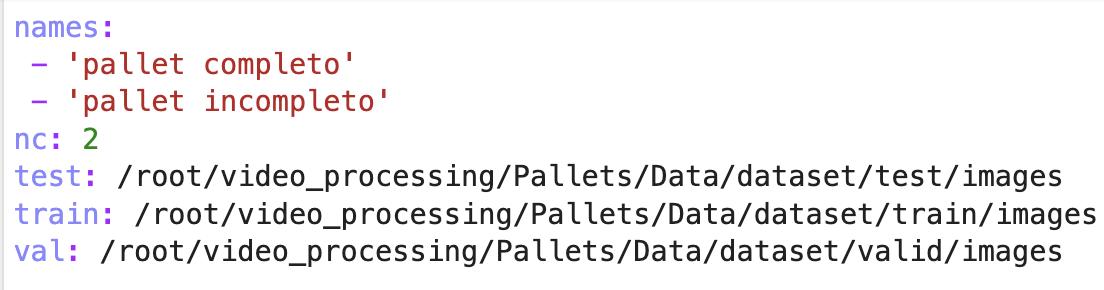